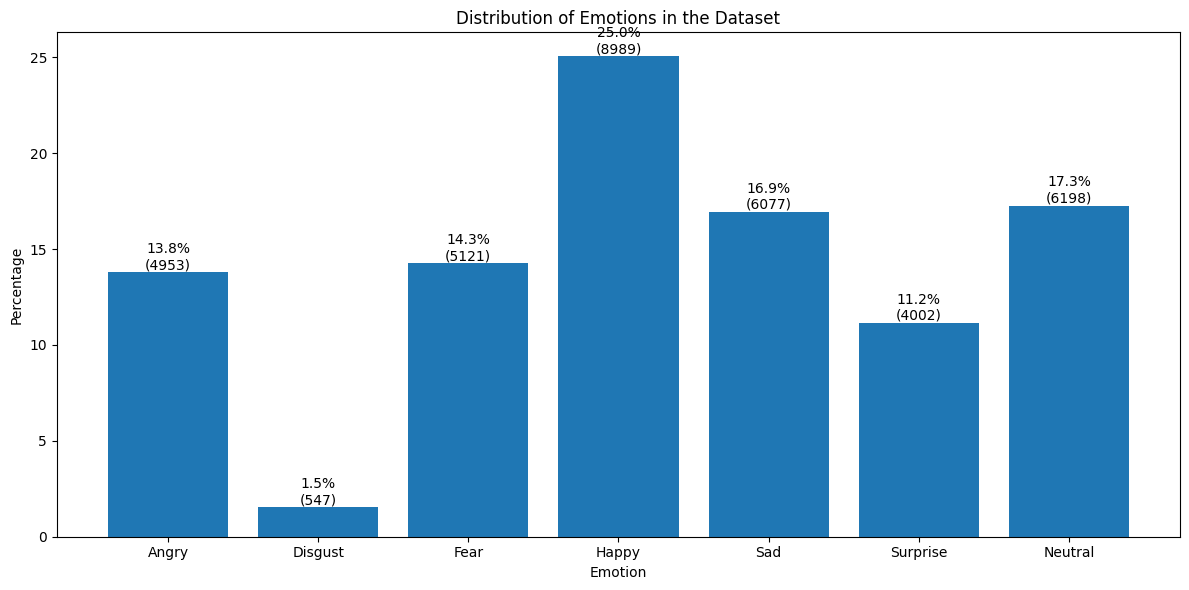

Emotion distribution:
Angry: 4953 (13.8%)
Disgust: 547 (1.5%)
Fear: 5121 (14.3%)
Happy: 8989 (25.0%)
Sad: 6077 (16.9%)
Surprise: 4002 (11.2%)
Neutral: 6198 (17.3%)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 讀取數據
df = pd.read_csv('fer2013.csv')

# 計算每種情緒的數量
emotion_counts = df['emotion'].value_counts().sort_index()

# 計算百分比
emotion_percentages = emotion_counts / len(df) * 100

# 創建一個字典來映射數字標籤到情緒名稱
emotion_labels = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
    4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

# 創建條形圖
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(emotion_counts)), emotion_percentages)

# 添加標籤和標題
plt.xlabel('Emotion')
plt.ylabel('Percentage')
plt.title('Distribution of Emotions in the Dataset')
plt.xticks(range(len(emotion_counts)), [emotion_labels[i] for i in emotion_counts.index])

# 在每個條形上添加具體數值
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{emotion_percentages[i]:.1f}%\n({emotion_counts[i]})',
             ha='center', va='bottom')

# 顯示圖表
plt.tight_layout()
plt.show()

# 打印具體數字
print("Emotion distribution:")
for i in emotion_counts.index:
    print(f"{emotion_labels[i]}: {emotion_counts[i]} ({emotion_percentages[i]:.1f}%)")

### Train

c:\Users\rolan\anaconda3\envs\main\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rolan\anaconda3\envs\main\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
Train Loss: 1.3311, Train Accuracy: 46.17%
Val Loss: 1.1841, Val Accuracy: 56.96%
---
Epoch 2/50
Train Loss: 1.1450, Train Accuracy: 54.94%
Val Loss: 1.1126, Val Accuracy: 58.39%
---
Epoch 3/50
Train Loss: 1.0636, Train Accuracy: 58.29%
Val Loss: 1.1112, Val Accuracy: 58.56%
---
Epoch 4/50
Train Loss: 1.0263, Train Accuracy: 60.13%
Val Loss: 1.0438, Val Accuracy: 61.04%
---
Epoch 5/50
Train Loss: 0.9859, Train Accuracy: 61.60%
Val Loss: 1.0371, Val Accuracy: 61.18%
---
Epoch 6/50
Train Loss: 0.9540, Train Accuracy: 62.89%
Val Loss: 1.0472, Val Accuracy: 61.32%
---
Epoch 7/50
Train Loss: 0.9266, Train Accuracy: 63.95%
Val Loss: 1.0383, Val Accuracy: 62.89%
---
Epoch 8/50
Train Loss: 0.8946, Train Accuracy: 65.57%
Val Loss: 0.9868, Val Accuracy: 63.74%
---
Epoch 9/50
Train Loss: 0.8579, Train Accuracy: 67.13%
Val Loss: 1.0467, Val Accuracy: 62.25%
---
Epoch 10/50
Train Loss: 0.8396, Train Accuracy: 67.65%
Val Loss: 0.9793, Val Accuracy: 64.76%
---
Epoch 11/50
Train Loss: 0.812

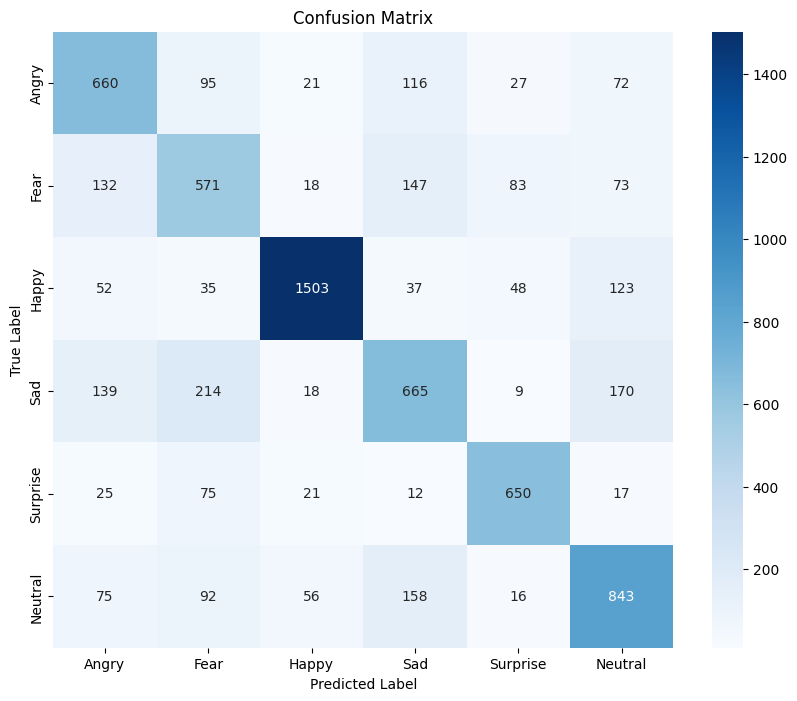

Finished Training


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class EmotionDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.features[idx].reshape(48, 48)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label)

# 數據增強
train_transform = transforms.Compose([
    transforms.ToPILImage(), # 將數組轉換為 PIL.Image
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # 平移
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# 讀取數據
df = pd.read_csv('fer2013.csv')
# 移除 Disgust 類別（假設 Disgust 的標籤是 1）
df = df[df['emotion'] != 1]
# 重新映射標籤
emotion_map = {0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
df['emotion'] = df['emotion'].map(emotion_map)

X = np.array([np.array(x.split()).astype(np.float32) for x in df['pixels']])
y = df['emotion'].values

# 分割數據
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 創建數據集
train_dataset = EmotionDataset(X_train, y_train, train_transform)
val_dataset = EmotionDataset(X_val, y_val, val_transform)

# 計算類別權重
class_counts = np.bincount(y_train)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[y_train]
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

# 數據加載器
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 模型、損失函數和優化器
model = resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 6)  # 修改為6個輸出
criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 早停
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping()

# 訓練循環
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # 驗證
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print('---')

    # 早停檢查
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# 錯誤分析
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

emotion_labels = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

# 繪製混淆矩陣
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print('Finished Training')

In [4]:
# 保存模型
torch.save(model.state_dict(), 'initial_model.pth')

### Fine Tune

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from albumentations import (
    Compose, Resize, HorizontalFlip, Rotate, ShiftScaleRotate,
    RandomBrightnessContrast, Normalize
)
from albumentations.pytorch import ToTensorV2

class EmotionDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.features[idx].reshape(48, 48).astype(np.uint8)
        label = self.labels[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, torch.tensor(label)

# 數據增強
train_transform = Compose([
    Resize(224, 224),
    HorizontalFlip(p=0.5),
    Rotate(limit=10, p=0.5),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    Normalize(mean=[0.485], std=[0.229]),
    ToTensorV2()
])

val_transform = Compose([
    Resize(224, 224),
    Normalize(mean=[0.485], std=[0.229]),
    ToTensorV2()
])

# 載入新數據集
new_df = pd.read_csv('new_fer2013.csv')
# 假設新數據集的 Disgust 類別標籤為 1
new_df = new_df[new_df['emotion'] != 1]
new_df['emotion'] = new_df['emotion'].map(emotion_map)

new_X = np.array([np.array(x.split()).astype(np.float32) for x in new_df['pixels']])
new_y = new_df['emotion'].values

# 分割新數據集
new_X_train, new_X_val, new_y_train, new_y_val = train_test_split(new_X, new_y, test_size=0.2, random_state=42, stratify=new_y)

# 創建新數據集
new_train_dataset = EmotionDataset(new_X_train, new_y_train, transform=train_transform)
new_val_dataset = EmotionDataset(new_X_val, new_y_val, transform=val_transform)

# 計算類別權重
new_class_counts = np.bincount(new_y_train)
new_class_weights = 1. / torch.tensor(new_class_counts, dtype=torch.float)
new_sample_weights = new_class_weights[new_y_train]
new_sampler = torch.utils.data.WeightedRandomSampler(new_sample_weights, len(new_sample_weights))

# 新數據加載器
new_train_loader = DataLoader(new_train_dataset, batch_size=32, sampler=new_sampler)
new_val_loader = DataLoader(new_val_dataset, batch_size=32, shuffle=False)

# 載入初步模型並微調
model = resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 6)  # 確保輸出維度正確
model.load_state_dict(torch.load('initial_model.pth'))
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=new_class_weights.cuda())
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# 訓練和驗證循環
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for inputs, labels in new_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(new_train_loader)

    # 驗證
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in new_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(new_val_loader)

    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print('---')

    # 早停檢查
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# 錯誤分析
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

emotion_labels = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

# 繪製混淆矩陣
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'final_model.pth')

In [1]:
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import numpy as np

# 設置計算設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 讀取訓練好的模型
model_path = 'initial_model.pth'
model = resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 6)

# 嘗試加載模型
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
except FileNotFoundError:
    print(f"Model file not found: {model_path}")
    exit()
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

model.eval()
model.to(device)

# 設置 OpenCV 人臉檢測器
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 設置數據轉換
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# 打開鏡頭
cap = cv2.VideoCapture(0)

emotion_labels = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# 設置擴展邊距的比例
margin = 0.2  # 20% 的邊距

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(44, 44))

    for (x, y, w, h) in faces:
        # 擴大邊框以包含更多周圍區域
        x1 = max(x - int(margin * w), 0)
        y1 = max(y - int(margin * h), 0)
        x2 = min(x + w + int(margin * w), frame.shape[1])
        y2 = min(y + h + int(margin * h), frame.shape[0])

        face_img = gray[y1:y2, x1:x2]
        
        # 縮放圖像至 48x48 像素
        face_img_resized = cv2.resize(face_img, (48, 48))
        
        # 將縮放後的圖像轉換為 numpy float32 格式
        face_img_np = face_img_resized.astype(np.float32)
        
        # 將 numpy array 轉換為 PIL 圖像並進行變換
        face_img_pil = Image.fromarray(face_img_np)
        face_img_transformed = transform(face_img_np)
        face_img_tensor = face_img_transformed.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(face_img_tensor)
            probabilities = torch.softmax(outputs, dim=1)  # 計算每一類的機率
            _, predicted = torch.max(outputs, 1)
            emotion = emotion_labels[predicted.item()]

            # 顯示每一類的機率
            prob_texts = [f"{emotion_labels[i]}: {probabilities[0, i].item():.2f}" for i in range(len(emotion_labels))]

        # 繪製擴大的偵測框和預測情緒
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, emotion, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        # 顯示每一類機率
        y_offset = y1 - 50
        for prob_text in prob_texts:
            cv2.putText(frame, prob_text, (x1, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            y_offset += 20

        # 顯示預測圖像按鈕
        if cv2.waitKey(1) & 0xFF == ord('s'):  # 按 's' 鍵顯示預測圖像
            face_img_np_display = np.array(face_img)  # 在這裡 face_img_pil 已經被定義
            cv2.imshow('Predicted Image', face_img_np_display)

    cv2.imshow('Emotion Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


c:\Users\rolan\anaconda3\envs\main\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rolan\anaconda3\envs\main\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
# 讀取包含空格的字串
input_string = "70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92 57 62 53 47 41 40 51 43 24 35 52 63 75 104 129 143 149 158 162 164 166 171 173 172 174 178 178 179 187 188 188 191 193 194 195 198 199 199 197 198 197 197 197 201 164 52 78 87 69 58 56 50 54 39 44 42 26 31 49 65 91 119 134 145 147 152 159 163 167 171 170 169 174 178 178 179 187 187 185 187 190 188 187 191 197 201 199 199 200 197 196 197 182 58 62 77 61 60 55 49 59 52 54 44 22 30 47 68 102 123 136 144 148 150 153 157 167 172 173 170 171 177 179 178 186 190 186 189 196 193 191 194 190 190 192 197 201 203 199 194 189 69 48 74 56 60 57 50 59 59 51 41 20 34 47 79 111 132 139 143 145 147 150 151 160 169 172 171 167 171 177 177 174 180 182 181 192 196 189 192 198 195 194 196 198 201 202 195 189 70 39 69 61 61 61 53 59 59 45 40 26 40 61 93 124 135 138 142 144 146 151 152 158 165 168 168 165 161 164 173 172 167 172 167 180 198 198 193 199 195 194 198 200 198 197 195 190 65 35 68 59 59 62 57 60 59 50 44 32 54 90 115 132 137 138 140 144 146 146 156 165 168 174 176 176 175 168 168 169 171 175 171 172 192 194 184 198 205 201 194 195 193 195 192 186 57 38 72 65 57 62 58 57 60 54 49 47 79 116 130 138 141 141 139 141 143 145 157 164 164 166 173 174 176 179 179 176 181 189 188 173 180 175 160 182 189 198 192 189 190 190 188 172 46 44 64 66 59 62 57 56 62 53 50 66 103 133 137 141 143 141 136 132 131 136 127 118 111 107 108 123 131 143 154 158 166 177 181 175 170 159 148 171 161 176 185 192 194 188 190 162 53 49 58 63 61 61 55 56 61 51 50 81 116 139 142 142 146 144 136 128 119 112 97 85 90 91 88 92 90 80 81 84 106 122 132 144 145 144 147 163 147 163 173 181 190 187 191 167 61 48 53 61 61 58 54 56 61 51 53 89 123 140 144 145 146 147 136 122 107 99 95 92 90 87 83 76 67 52 46 52 63 69 83 96 119 132 148 159 136 137 143 138 143 152 156 156 70 48 50 59 61 57 54 54 61 52 56 93 124 135 140 144 148 150 140 125 114 101 80 54 56 54 41 41 33 40 39 35 49 60 63 74 107 129 147 147 116 111 100 77 76 86 108 111 73 49 50 60 62 60 57 55 63 59 56 89 121 134 139 146 151 152 150 141 127 111 96 77 85 70 32 31 37 91 65 50 48 59 73 83 112 136 155 130 60 46 38 40 43 81 116 91 72 52 48 58 62 62 59 53 61 59 52 85 114 134 140 147 154 159 158 153 145 143 150 126 121 125 68 45 89 137 95 70 78 75 95 109 131 153 171 94 23 16 32 82 82 65 113 77 71 54 48 56 62 62 60 53 60 56 52 75 108 133 141 149 158 166 169 167 163 156 155 146 112 119 134 127 142 140 121 117 129 114 120 129 146 174 191 98 46 33 33 109 147 98 109 67 73 55 50 56 64 64 61 58 61 53 54 64 106 129 140 148 159 169 175 176 174 165 159 156 145 120 115 124 127 131 133 141 147 142 141 147 161 182 202 154 114 96 100 158 158 153 123 61 76 57 48 56 64 64 63 62 61 54 55 44 97 131 137 147 158 168 177 181 183 179 170 168 169 165 155 152 151 152 154 162 165 158 153 158 168 187 206 186 147 135 144 145 152 178 115 57 74 58 48 58 64 63 63 59 63 55 53 66 104 130 132 144 153 162 170 180 185 187 181 178 182 180 177 173 171 171 177 176 172 164 161 167 164 185 207 197 173 152 141 141 161 191 104 54 69 60 48 57 65 62 60 57 64 55 50 94 111 124 130 135 150 159 163 172 179 184 184 178 178 177 173 171 174 177 178 176 169 165 161 163 161 180 205 201 183 171 177 178 180 194 101 55 65 60 47 55 65 63 59 58 63 57 52 90 105 117 122 130 143 153 157 163 171 174 182 183 182 178 174 175 175 177 175 172 163 161 159 157 162 178 200 201 188 181 172 177 187 198 98 57 63 61 48 52 61 64 63 60 65 57 51 95 104 113 117 127 136 145 152 156 162 162 165 173 177 182 183 183 180 181 177 165 153 154 152 153 160 174 193 200 188 185 180 182 192 196 101 60 60 56 49 50 60 66 64 62 64 59 53 99 104 111 112 118 132 142 147 155 158 160 159 162 171 176 184 186 183 180 169 154 141 135 145 155 164 180 196 205 188 189 188 189 193 192 98 61 64 55 49 49 60 66 63 64 63 60 57 99 105 108 112 113 125 139 143 150 155 158 164 169 174 176 182 183 182 177 163 141 133 147 151 164 170 185 200 210 194 188 192 186 185 180 88 64 67 60 46 50 59 65 64 64 64 59 56 101 103 108 109 109 118 134 143 143 147 155 159 166 171 174 177 179 178 172 153 129 143 161 159 166 171 186 197 207 203 185 191 183 179 164 73 67 67 66 48 50 57 65 65 63 64 61 57 103 108 114 112 110 115 128 138 144 145 152 156 159 164 168 172 172 169 161 139 125 147 156 161 162 164 180 188 188 197 185 187 181 180 137 65 70 68 70 52 47 53 62 65 63 65 61 58 105 109 112 120 113 112 122 134 141 149 150 153 155 159 164 167 167 162 152 134 115 126 119 106 99 109 141 158 150 155 175 184 176 175 106 63 70 68 68 50 46 50 57 63 63 64 61 59 107 110 110 117 117 114 117 128 137 147 148 150 153 156 161 162 163 156 150 148 105 70 45 26 25 47 73 74 79 128 177 180 173 157 77 66 68 67 68 52 49 51 56 62 62 62 62 60 101 107 108 114 115 114 117 125 134 143 148 149 152 154 158 160 158 155 160 158 132 88 73 73 64 52 66 91 138 160 174 173 171 125 64 67 63 64 68 54 50 49 54 60 60 60 62 60 98 105 105 109 111 114 117 125 131 139 145 148 153 153 156 157 156 161 168 165 153 139 122 115 105 89 103 150 182 161 171 173 162 89 64 64 62 64 69 56 48 49 56 58 60 59 62 60 89 99 108 106 109 111 119 120 125 134 140 146 152 153 153 153 156 159 162 160 150 136 129 133 133 122 133 148 178 168 168 175 132 61 67 66 65 63 69 57 47 50 55 58 59 61 62 60 89 96 105 107 105 107 117 120 123 124 133 141 149 153 151 145 151 145 139 140 138 128 126 124 129 125 136 142 164 172 168 168 87 58 67 63 62 61 69 57 39 44 55 56 59 63 62 62 84 91 92 98 102 103 113 119 121 118 128 138 146 151 147 142 140 128 127 128 129 126 135 140 135 130 143 146 149 166 174 131 62 65 62 59 67 63 68 83 89 65 42 52 60 60 62 63 77 84 84 91 99 101 107 112 117 118 122 134 145 149 144 134 127 127 129 130 134 125 126 132 152 153 151 150 151 165 171 87 59 65 64 61 58 86 122 138 208 207 154 71 52 56 55 56 69 77 83 85 93 91 102 112 116 118 119 127 140 144 142 131 112 95 85 75 62 58 56 59 87 88 83 127 142 165 149 62 65 62 59 77 113 192 156 84 185 196 197 168 81 70 75 69 58 65 73 82 81 79 95 107 114 116 116 123 136 142 136 132 131 102 71 58 49 41 33 41 36 49 60 99 136 168 111 53 63 71 138 186 203 195 146 87 91 72 79 95 103 82 61 74 55 57 68 75 76 77 84 96 106 110 111 121 130 138 136 142 153 159 152 152 154 145 133 136 147 158 156 155 147 158 74 57 60 123 181 174 126 89 72 67 57 43 55 67 76 86 60 45 51 45 52 68 75 73 77 88 96 100 104 113 115 121 134 146 149 146 149 148 155 168 174 179 178 169 169 174 161 131 44 47 82 150 168 136 104 75 66 80 67 58 48 54 68 88 121 102 51 45 38 53 66 65 70 86 92 96 102 103 109 116 130 136 136 133 136 138 137 135 128 130 143 158 165 164 147 87 62 74 123 160 170 100 99 107 79 71 86 75 57 45 49 65 122 130 43 48 40 39 55 61 59 71 82 87 88 93 105 118 123 128 130 124 111 98 94 88 67 55 84 129 147 148 105 48 82 142 161 164 164 76 72 85 100 88 72 90 84 54 48 54 73 100 73 36 44 31 37 53 51 55 67 74 77 87 97 108 118 125 132 122 106 86 80 82 75 73 83 110 129 126 46 22 130 177 196 193 166 72 52 54 73 100 92 75 99 95 65 68 61 63 91 65 42 37 22 28 39 44 57 68 74 83 92 101 119 131 143 141 134 136 140 139 134 136 139 138 136 85 23 114 202 198 199 180 173 98 36 86 130 150 137 99 77 101 99 72 56 43 77 82 79 70 56 28 20 25 36 50 63 73 83 98 111 124 139 156 160 159 169 168 165 163 159 149 114 43 26 133 183 192 177 152 137 130 125 139 173 195 186 137 101 88 101 105 70 46 77 72 84 87 87 81 64 37 20 31 40 46 65 88 108 110 125 149 157 153 162 164 158 159 154 140 78 21 11 61 144 168 173 157 138 150 148 132 159 182 183 136 106 116 95 106 109 82"

# 將空格替換為換行符號
output_string = input_string.replace(" ", "\n")

# 輸出結果
print(output_string)


70
80
82
72
58
58
60
63
54
58
60
48
89
115
121
119
115
110
98
91
84
84
90
99
110
126
143
153
158
171
169
172
169
165
129
110
113
107
95
79
66
62
56
57
61
52
43
41
65
61
58
57
56
69
75
70
65
56
54
105
146
154
151
151
155
155
150
147
147
148
152
158
164
172
177
182
186
189
188
190
188
180
167
116
95
103
97
77
72
62
55
58
54
56
52
44
50
43
54
64
63
71
68
64
52
66
119
156
161
164
163
164
167
168
170
174
175
176
178
179
183
187
190
195
197
198
197
198
195
191
190
145
86
100
90
65
57
60
54
51
41
49
56
47
38
44
63
55
46
52
54
55
83
138
157
158
165
168
172
171
173
176
179
179
180
182
185
187
189
189
192
197
200
199
196
198
200
198
197
177
91
87
96
58
58
59
51
42
37
41
47
45
37
35
36
30
41
47
59
94
141
159
161
161
164
170
171
172
176
178
179
182
183
183
187
189
192
192
194
195
200
200
199
199
200
201
197
193
111
71
108
69
55
61
51
42
43
56
54
44
24
29
31
45
61
72
100
136
150
159
163
162
163
170
172
171
174
177
177
180
187
186
187
189
192
192
194
195
196
197
199
200
201
200
197
201
137
58
98
92
